In [2]:
import os, time, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import timm
from transformers import BertTokenizer, BertModel
from peft import LoraConfig, get_peft_model

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")

OBJECTS = [
    "bottle", "cable", "capsule", "carpet", "grid",
    "hazelnut", "leather", "metal_nut", "pill", "screw",
    "tile", "toothbrush", "transistor", "wood", "zipper"
]

NUM_CLASSES = len(OBJECTS)

Mounted at /content/drive


In [5]:
class MVTecObjectDataset(Dataset):
    def __init__(self, root, split="train", transform=None):
        self.samples = []
        self.transform = transform

        for obj_id, obj in enumerate(OBJECTS):
            base = Path(root) / obj / split
            for defect in base.iterdir():
                for img_path in defect.glob("*.png"):
                    self.samples.append((img_path, obj_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [6]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [7]:
train_ds = MVTecObjectDataset(MVTEC_ROOT, "train", train_tfms)
test_ds  = MVTecObjectDataset(MVTEC_ROOT, "test",  val_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

print("Train:", len(train_ds), " Test:", len(test_ds))

Train: 3630  Test: 1725


In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_encoder = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
text_encoder.eval()

for p in text_encoder.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
prompts = [f"a photo of a {o}" for o in OBJECTS]
tokens = tokenizer(
    prompts,
    padding=True,
    truncation=True,
    return_tensors="pt"
).to(DEVICE)

with torch.no_grad():
    txt_feat = text_encoder(**tokens).pooler_output
    txt_feat = txt_feat / txt_feat.norm(dim=1, keepdim=True)

In [10]:
vit = timm.create_model(
    "vit_small_patch16_224",
    pretrained=True,
    num_classes=0
)

lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["qkv"],
    lora_dropout=0.1,
    bias="none"
)

vit = get_peft_model(vit, lora_cfg).to(DEVICE)

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [11]:
img_proj = nn.Linear(vit.num_features, txt_feat.shape[1]).to(DEVICE)

for p in img_proj.parameters():
    p.requires_grad = False

In [12]:
optimizer = torch.optim.AdamW(
    vit.parameters(),
    lr=1e-4
)

EPOCHS = 10

In [16]:
train_start = time.time()

for epoch in range(EPOCHS):
    vit.train()
    total_loss = 0
    ep_start = time.time()

    for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        img_feat = vit(imgs)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        target = txt_feat[labels]
        loss = 1 - (img_feat * target).sum(dim=1).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(
        f"Epoch {epoch+1} | "
        f"Loss: {total_loss/len(train_dl):.4f} | "
        f"Time: {(time.time()-ep_start)/60:.2f} min"
    )

train_time = time.time() - train_start
print(f"\nTOTAL TRAIN TIME: {train_time/60:.2f} minutes")

Epoch 1/10: 100%|██████████| 114/114 [10:19<00:00,  5.43s/it]


Epoch 1 | Loss: 0.6584 | Time: 10.32 min


Epoch 2/10: 100%|██████████| 114/114 [02:29<00:00,  1.31s/it]


Epoch 2 | Loss: 0.3665 | Time: 2.50 min


Epoch 3/10: 100%|██████████| 114/114 [02:27<00:00,  1.29s/it]


Epoch 3 | Loss: 0.3263 | Time: 2.46 min


Epoch 4/10: 100%|██████████| 114/114 [02:24<00:00,  1.27s/it]


Epoch 4 | Loss: 0.3161 | Time: 2.42 min


Epoch 5/10: 100%|██████████| 114/114 [02:25<00:00,  1.27s/it]


Epoch 5 | Loss: 0.3108 | Time: 2.42 min


Epoch 6/10: 100%|██████████| 114/114 [02:24<00:00,  1.26s/it]


Epoch 6 | Loss: 0.3071 | Time: 2.40 min


Epoch 7/10: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]


Epoch 7 | Loss: 0.3044 | Time: 2.40 min


Epoch 8/10: 100%|██████████| 114/114 [02:21<00:00,  1.24s/it]


Epoch 8 | Loss: 0.3025 | Time: 2.36 min


Epoch 9/10: 100%|██████████| 114/114 [02:24<00:00,  1.27s/it]


Epoch 9 | Loss: 0.3012 | Time: 2.41 min


Epoch 10/10: 100%|██████████| 114/114 [02:21<00:00,  1.24s/it]

Epoch 10 | Loss: 0.3001 | Time: 2.35 min

TOTAL TRAIN TIME: 32.04 minutes


In [18]:
vit.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(DEVICE)

        img_feat = vit(imgs)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        sims = img_feat @ txt_feat.T
        preds = sims.argmax(dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

In [19]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

correct = (y_true == y_pred).sum()
acc = correct / len(y_true)

print(f"REAL Accuracy: {acc*100:.4f}%")
print("Errors:", len(y_true) - correct)

REAL Accuracy: 43.1304%
Errors: 981


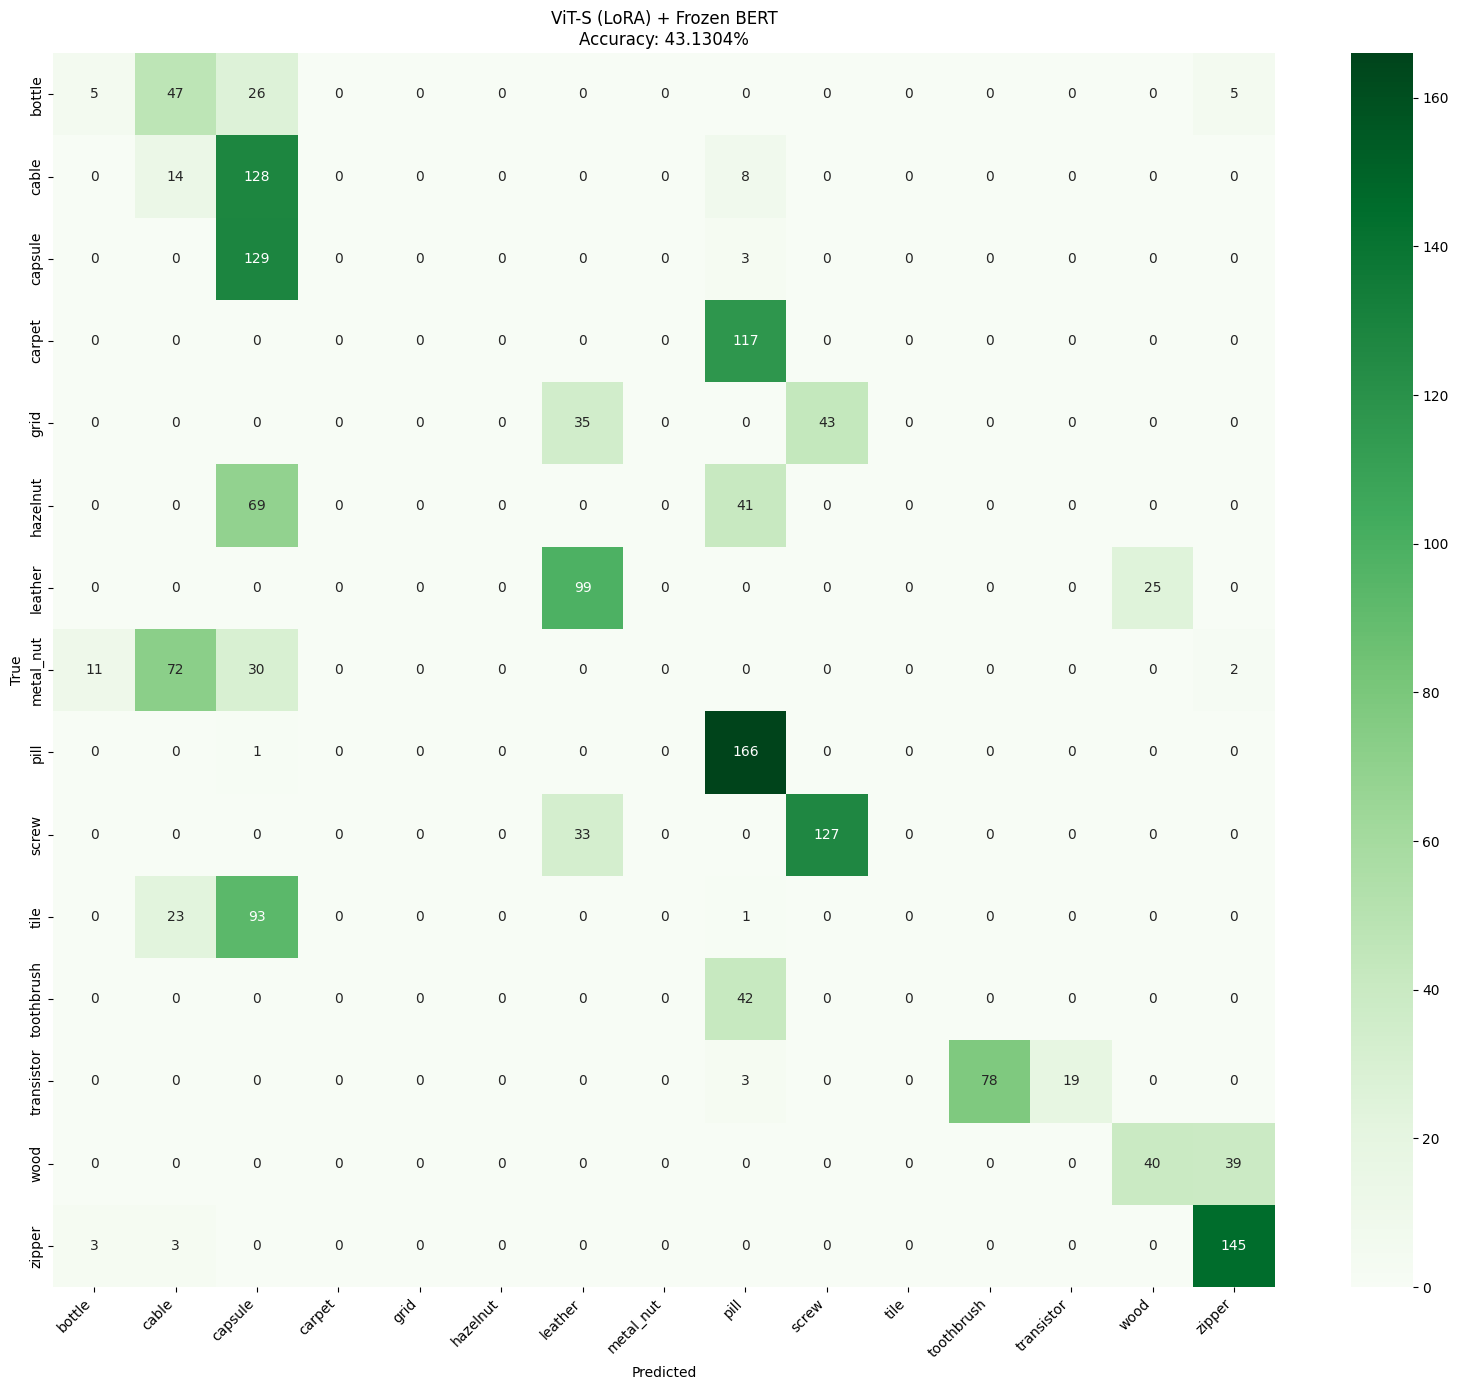

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16,14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Greens"
)
plt.title(f"ViT-S (LoRA) + Frozen BERT\nAccuracy: {acc*100:.4f}%")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [21]:
print(
    classification_report(
        y_true, y_pred,
        target_names=OBJECTS,
        digits=4
    )
)

              precision    recall  f1-score   support

      bottle     0.2632    0.0602    0.0980        83
       cable     0.0881    0.0933    0.0906       150
     capsule     0.2710    0.9773    0.4243       132
      carpet     0.0000    0.0000    0.0000       117
        grid     0.0000    0.0000    0.0000        78
    hazelnut     0.0000    0.0000    0.0000       110
     leather     0.5928    0.7984    0.6804       124
   metal_nut     0.0000    0.0000    0.0000       115
        pill     0.4357    0.9940    0.6058       167
       screw     0.7471    0.7937    0.7697       160
        tile     0.0000    0.0000    0.0000       117
  toothbrush     0.0000    0.0000    0.0000        42
  transistor     1.0000    0.1900    0.3193       100
        wood     0.6154    0.5063    0.5556        79
      zipper     0.7592    0.9603    0.8480       151

    accuracy                         0.4313      1725
   macro avg     0.3182    0.3582    0.2928      1725
weighted avg     0.3478   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
vit.eval()
dummy = torch.randn(1,3,224,224).to(DEVICE)

# warmup
for _ in range(20):
    _ = vit(dummy)

N = 100
start = time.time()
for _ in range(N):
    _ = vit(dummy)
end = time.time()

lat = (end - start) / N * 1000
print(f"Inference latency: {lat:.2f} ms / image")

Inference latency: 13.45 ms / image


Load the model directly

In [23]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_PATH = "/content/drive/MyDrive/new-step2_vits_lora.pth"

torch.save({
    "vit_state": vit.state_dict(),
    "img_proj_state": img_proj.state_dict(),
    "objects": OBJECTS,
}, SAVE_PATH)

print("aved to Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
aved to Google Drive


In [24]:
import torch
import torch.nn as nn
import timm
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [25]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OBJECTS = [
    "bottle", "cable", "capsule", "carpet", "grid",
    "hazelnut", "leather", "metal_nut", "pill", "screw",
    "tile", "toothbrush", "transistor", "wood", "zipper"
]

In [26]:
vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
lora_cfg = LoraConfig(
    r=8, lora_alpha=16, target_modules=["qkv"], lora_dropout=0.1, bias="none"
)
vit = get_peft_model(vit, lora_cfg).to(DEVICE)

img_proj = nn.Linear(vit.num_features, 768).to(DEVICE)

In [28]:
SAVE_PATH = "/content/drive/MyDrive/new-step2_vits_lora.pth"
checkpoint = torch.load(SAVE_PATH)
vit.load_state_dict(checkpoint["vit_state"])
img_proj.load_state_dict(checkpoint["img_proj_state"])

vit.eval()
img_proj.eval()

Linear(in_features=384, out_features=768, bias=True)

In [29]:
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(DEVICE)
        img_feat = vit(imgs)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        sims = img_feat @ txt_feat.T
        preds = sims.argmax(dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

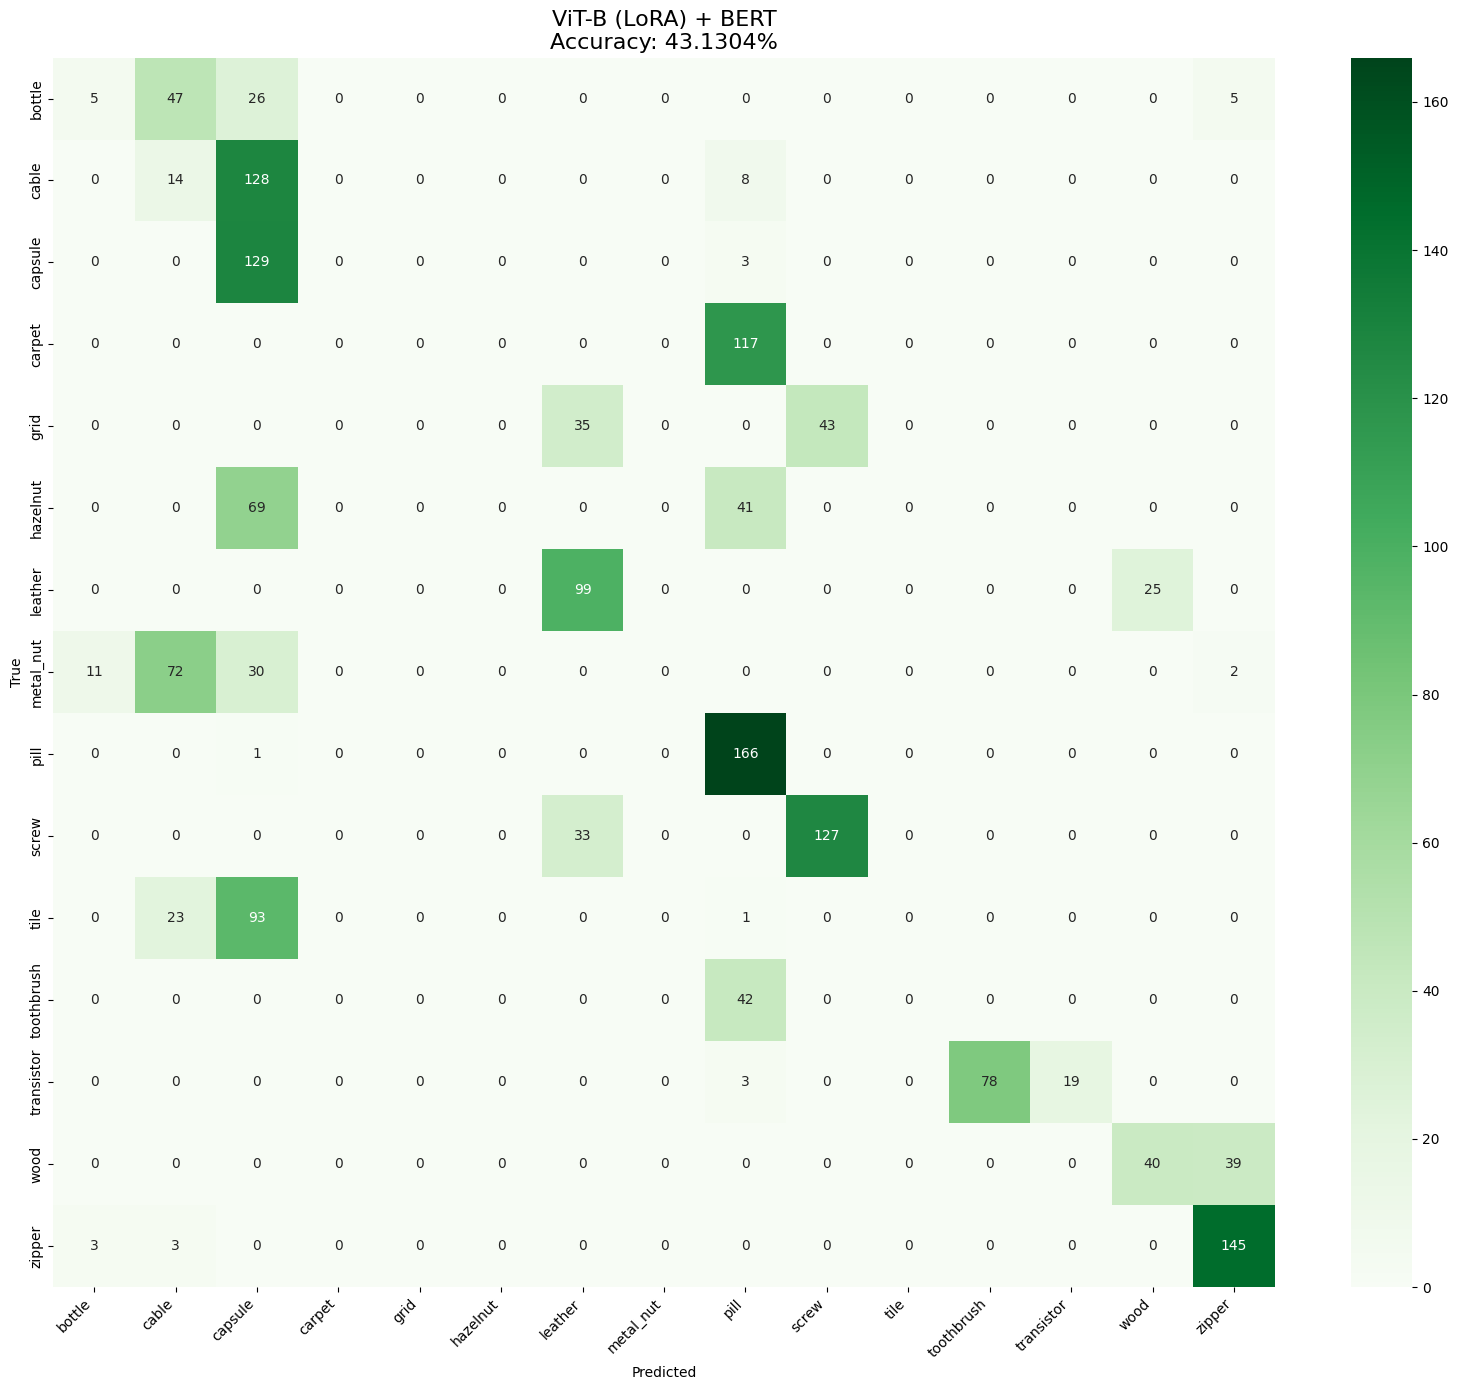


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      bottle     0.2632    0.0602    0.0980        83
       cable     0.0881    0.0933    0.0906       150
     capsule     0.2710    0.9773    0.4243       132
      carpet     0.0000    0.0000    0.0000       117
        grid     0.0000    0.0000    0.0000        78
    hazelnut     0.0000    0.0000    0.0000       110
     leather     0.5928    0.7984    0.6804       124
   metal_nut     0.0000    0.0000    0.0000       115
        pill     0.4357    0.9940    0.6058       167
       screw     0.7471    0.7937    0.7697       160
        tile     0.0000    0.0000    0.0000       117
  toothbrush     0.0000    0.0000    0.0000        42
  transistor     1.0000    0.1900    0.3193       100
        wood     0.6154    0.5063    0.5556        79
      zipper     0.7592    0.9603    0.8480       151

    accuracy                         0.4313      1725
   macro avg     0.3182    0.3582    0.2928     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
acc = accuracy_score(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Greens"
)
plt.title(f"ViT-B (LoRA) + BERT\nAccuracy: {acc*100:.4f}%", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(
    classification_report(
        y_true, y_pred,
        target_names=OBJECTS,
        digits=4
    )
)